In [ ]:
import wrf as w
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import pandas as pd 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import cmaps
import os 
from zMap import set_grid, add_NamCo
from zIO import load_prec, load_cmfd, load_wrflist
import warnings
warnings.filterwarnings("ignore")

if __name__ == '__main__':
    data_dir = '/home/zzhzhao/Model/wrfout'
    testname_list = [
        'cmfd',
        'test-25-3',
        'test-25-NL',
        'test-25-NM',
        ]
    
    N_test = len(testname_list)
    # NamCo_latlon = (30.75, 90.8)
    lat_range = (30, 31.5)
    lon_range = (90, 91.5)
    date_start = '2013-08-23'
    date_end = '2013-09-01'

    prec_mean_list = dict()
    for testname in testname_list:
        if testname == 'cmfd':
            cmfd = load_cmfd(date_start, date_end, lat_range, lon_range)
            prec_mean_list[testname] = cmfd.mean(dim=['lat', 'lon']).resample(time='1D').sum()
        elif testname == 'obs':
            df = pd.read_excel('data/纳木错站2017-2018.xlsx', index_col=0)
            obs_sta = df.loc[pd.date_range(date_start, date_end)]['降水量']
            prec_mean_list[testname] = obs_sta
        else:
            data_path = os.path.join(data_dir, testname)
            domain = 1
            prec, lats, lons, time = load_prec(data_path, domain)
            wrflist = load_wrflist(data_path, domain)
            prec = xr.where(prec>0, prec, np.nan)
            ### 纳木错站点插值
            left_bottom = w.ll_to_xy(wrflist, lat_range[0], lon_range[0]).values
            right_top = w.ll_to_xy(wrflist, lat_range[1], lon_range[1]).values
            prec_mean = prec.sel(south_north=slice(left_bottom[1], right_top[1]), west_east=slice(left_bottom[0], right_top[0])).mean(dim=['south_north', 'west_east']).resample(Time='1D').sum()
            prec_mean_list[testname] = prec_mean

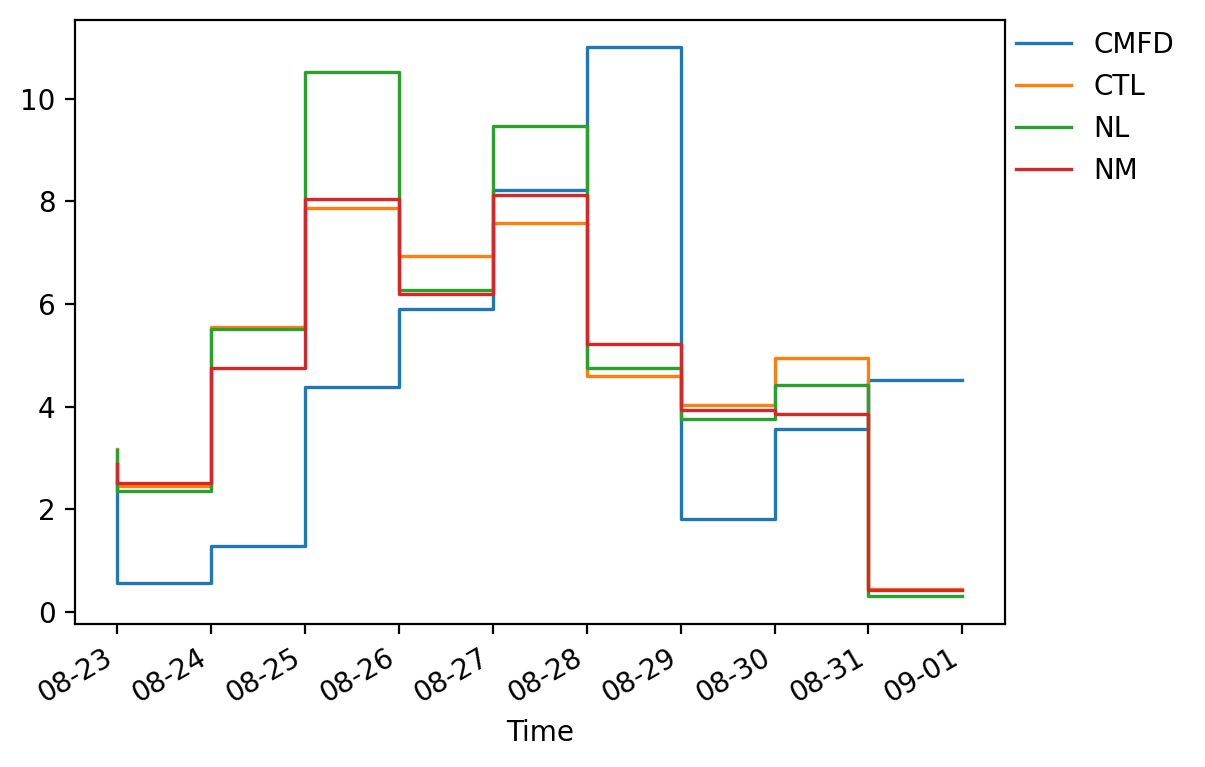

In [2]:
    labels = [
        'CMFD',
        'CTL',
        'NL', 
        'NM', 
        ]
    markers = list('PX^.sxD+*p')
    fig, ax = plt.subplots(dpi=200)
    for i, testname in enumerate(testname_list):
        var = prec_mean_list[testname]

        # var.plot.line(lw=0, marker=markers[i], mfc='none', label=labels[i], ax=ax)
        var.plot.step(lw=1.2, mfc='none', label=labels[i], ax=ax)
        ax.legend(loc=2, bbox_to_anchor=(1.0,1.0), borderaxespad=0, frameon=False)
        import matplotlib.dates as mdate  
        ax.xaxis.set_major_formatter(mdate.DateFormatter('%m-%d'))

    fig.savefig('fig/prec_ts_alltest.jpg', dpi=300, bbox_inches='tight', pad_inches=0.1)